In [3]:
# Cell 1: Configuration Parameters
config = {
    "dataset": {
        "path": "D:/Backblaze_Data/Training-Q1-data/",
        "days_before_failure": 30,
        "sequence_length": 30,
        "smart_attribute_numbers": [5, 187, 197, 198],
        "include_raw": True,
        "include_normalized": True,
    },
    "model": {
        "type": "simplenn",   # Adjust this to match your model implementation.
        "hidden_dim": 64
    },
    "experiment": {
        "num_trials": 10,
        "num_epochs": 5,
        "final_epochs": 5,
        "batch_size": 64,
        "k_folds": 3,
        "early_stopping_patience": 2,
    },
    "logging": {
        "tensorboard_log_dir": "./logs"
    }
}
print("Configuration loaded.")


Configuration loaded.


In [ ]:
# Cell 2: SMARTDataset Definition
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class SMARTDataset(Dataset):
    """
    PyTorch custom Dataset for SMART data.
    
    This dataset reads SMART attribute CSV files, filters and groups the data by drive,
    and generates sequences of SMART attributes from each drive (identified by serial number).
    A candidate sequence is a sliding window (of length sequence_length) ending at a given date.
    A candidate is accepted only if it has less than 25% missing SMART values and its sequential label 
    (per drive) is <= days_before_failure. Sequences are generated on-demand in __getitem__.
    
    Additionally, you can restrict the dataset to a set of drive serial numbers using the
    'drives_to_include' parameter.
    """
    def __init__(
        self,
        data_directory,
        models_to_include=None,
        drives_to_include=None,
        days_before_failure=30,
        sequence_length=10,
        smart_attribute_numbers=[5, 187, 197, 198],
        include_raw=True,
        include_normalized=True,
        scaler=None,  
        model_label_encoder=None,
    ):
        self.data_directory = data_directory
        self.models_to_include = models_to_include
        self.drives_to_include = drives_to_include  # restrict to these drive serial numbers if provided
        self.days_before_failure = days_before_failure  # Used as max sequence label per drive
        self.sequence_length = sequence_length
        self.smart_attribute_numbers = smart_attribute_numbers
        self.include_raw = include_raw
        self.include_normalized = include_normalized
        self.scaler = scaler  
        self.model_label_encoder = model_label_encoder

        # Define SMART attribute column names
        self.smart_attributes = []
        for num in self.smart_attribute_numbers:
            if self.include_raw:
                self.smart_attributes.append(f'smart_{num}_raw')
            if self.include_normalized:
                self.smart_attributes.append(f'smart_{num}_normalized')
        
        # Dictionaries to hold raw drive data and index mapping
        self.drive_data = {}          # Key: serial_number, Value: drive DataFrame (filtered & sorted)
        self.index_mapping = []       # List of tuples: (serial_number, end_date, sequence_label)
        
        self.process_data()

    def process_data(self):
        # --- Step 1. Read CSV files and build failure_date_dict ---
        all_files = glob.glob(os.path.join(self.data_directory, '*.csv'))
        all_files.sort()
        print(f"Found {len(all_files)} CSV files in '{self.data_directory}'.")
        
        failure_date_dict = {}
        for filename in all_files:
            try:
                df = pd.read_csv(filename, usecols=['date', 'serial_number', 'failure'])
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                continue
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df['failure'] = pd.to_numeric(df['failure'], errors='coerce')
            failures = df[df['failure'] == 1]
            if not failures.empty:
                for _, row in failures.iterrows():
                    serial_number = row['serial_number']
                    failure_date = row['date']
                    failure_date_dict[serial_number] = failure_date

        print(f"Number of drives with failure events: {len(failure_date_dict)}")
        if len(failure_date_dict) == 0:
            print("Warning: No drives with failure events found.")
        
        # --- Step 2. Collect data for failed drives ---
        failed_drives_data = defaultdict(list)
        cols = ['date', 'serial_number', 'model'] + self.smart_attributes + ['failure']
        for filename in all_files:
            try:
                df = pd.read_csv(filename, usecols=cols)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                continue
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df_failed = df[df['serial_number'].isin(failure_date_dict.keys())]
            if df_failed.empty:
                continue
            for serial_number, group in df_failed.groupby('serial_number'):
                failed_drives_data[serial_number].append(group)
        
        # --- Step 3. Filter drive data based on minimum unique dates ---
        filtered_data_list = []
        min_unique_days = max(1, 3 * self.days_before_failure // 4)
        print(f"Minimum unique dates required per drive: {min_unique_days}")
        for serial_number, data_list in failed_drives_data.items():
            drive_data = pd.concat(data_list, ignore_index=True)
            failure_date = failure_date_dict[serial_number].normalize()
            drive_data['date'] = drive_data['date'].dt.normalize()
            start_date = failure_date - pd.Timedelta(days=self.days_before_failure)
            drive_data = drive_data[(drive_data['date'] >= start_date) & (drive_data['date'] <= failure_date)]
            num_unique_dates = drive_data['date'].nunique()
            if num_unique_dates < min_unique_days:
                print(f"Drive {serial_number} skipped: only {num_unique_dates} unique dates (min required: {min_unique_days})")
                continue
            filtered_data_list.append(drive_data)
        if not filtered_data_list:
            raise ValueError("No drive data passed the filtering criteria.")
        filtered_data = pd.concat(filtered_data_list, ignore_index=True)
        
        # --- Step 4. Encode model types ---
        if self.model_label_encoder is None:
            le_model = LabelEncoder()
            filtered_data['model_encoded'] = le_model.fit_transform(filtered_data['model'])
            self.model_label_encoder = le_model
        else:
            filtered_data['model_encoded'] = self.model_label_encoder.transform(filtered_data['model'])
        self.model_mapping = dict(zip(self.model_label_encoder.classes_,
                                      self.model_label_encoder.transform(self.model_label_encoder.classes_)))
        
        # --- Optional: Filter by drives_to_include ---
        if self.drives_to_include is not None:
            filtered_data = filtered_data[filtered_data['serial_number'].isin(self.drives_to_include)].reset_index(drop=True)
        if self.models_to_include is not None:
            filtered_data = filtered_data[filtered_data['model_encoded'].isin(self.models_to_include)].reset_index(drop=True)
        
        # --- Step 5. Store raw drive data per drive ---
        grouped = filtered_data.groupby('serial_number')
        for serial_number, group in grouped:
            group = group.sort_values(by='date').reset_index(drop=True)
            drive_df = group.set_index('date')
            self.drive_data[serial_number] = drive_df
        
        # --- Step 6. Build index mapping for lazy sequence generation ---
        for drive, drive_df in self.drive_data.items():
            dates = sorted(drive_df.index.unique())
            seq_label = 0
            for current_date in dates:
                candidate = self._generate_sequence(drive, current_date)
                if candidate is None:
                    print(f"Candidate sequence for drive {drive} at {current_date} discarded: too many missing values.")
                    continue
                if seq_label <= self.days_before_failure:
                    self.index_mapping.append((drive, current_date, seq_label))
                else:
                    break
                seq_label += 1
        print(f"Total candidate sequences (index mapping length): {len(self.index_mapping)}")
        
        # --- Step 7. Fit scaler if not provided ---
        if self.scaler is None and self.index_mapping:
            sample_sequences = []
            for drive, current_date, seq_label in self.index_mapping:
                seq = self._generate_sequence(drive, current_date)
                if seq is not None:
                    sample_sequences.append(seq[1:])  # Exclude model_encoded
            if sample_sequences:
                sample_sequences = np.vstack(sample_sequences)
                scaler = StandardScaler()
                scaler.fit(sample_sequences)
                self.scaler = scaler
                print("Scaler fitted on sample candidate sequences.")
            else:
                print("Warning: No sequences available to fit the scaler.")

    def _generate_sequence(self, drive, end_date):
        drive_df = self.drive_data[drive]
        sequence_dates = [end_date - pd.Timedelta(days=i) for i in range(self.sequence_length - 1, -1, -1)]
        sequence_records = []
        for seq_date in sequence_dates:
            if seq_date in drive_df.index:
                row = drive_df.loc[seq_date]
                if isinstance(row, pd.DataFrame):
                    row = row.iloc[0]
                smart_values = [row.get(attr, np.nan) for attr in self.smart_attributes]
            else:
                smart_values = [np.nan] * len(self.smart_attributes)
            sequence_records.append(smart_values)
        sequence_arr = np.array(sequence_records).flatten()
        missing_count = np.isnan(sequence_arr).sum()
        total_values = self.sequence_length * len(self.smart_attributes)
        if missing_count >= 0.25 * total_values:
            return None
        sequence_arr = np.nan_to_num(sequence_arr, nan=0)
        model_encoded = drive_df['model_encoded'].iloc[0]
        features = np.concatenate(([model_encoded], sequence_arr))
        return features

    def __len__(self):
        return len(self.index_mapping)
    
    def __getitem__(self, idx):
        drive, end_date, seq_label = self.index_mapping[idx]
        sequence = self._generate_sequence(drive, end_date)
        if sequence is None:
            raise ValueError(f"Sequence for drive {drive} at {end_date} could not be generated.")
        if self.scaler is not None:
            sequence[1:] = self.scaler.transform(sequence[1:].reshape(1, -1))[0]
        features_tensor = torch.tensor(sequence, dtype=torch.float32)
        label_tensor = torch.tensor(seq_label, dtype=torch.float32).unsqueeze(0)
        return features_tensor, label_tensor

print("SMARTDataset defined.")


SMARTDataset defined.


[INFO] Using device: cpu
Found 91 CSV files in 'D:/Backblaze_Data/Training-Q1-data/'.
Number of drives with failure events: 978
Minimum unique dates required per drive: 22
Drive 10B0A0FJF97G skipped: only 4 unique dates (min required: 22)
Drive 10C0A01DF97G skipped: only 17 unique dates (min required: 22)
Drive 10K0A08QF97G skipped: only 18 unique dates (min required: 22)
Drive 10L0A0EFFV8G skipped: only 8 unique dates (min required: 22)
Drive 1290A07FFVKG skipped: only 5 unique dates (min required: 22)
Drive 13R0A09LFVKG skipped: only 5 unique dates (min required: 22)
Drive 13X0A04SFVKG skipped: only 5 unique dates (min required: 22)
Drive 177QT3DRT skipped: only 10 unique dates (min required: 22)
Drive 20W0A089F97G skipped: only 15 unique dates (min required: 22)
Drive 20W0A0SRF97G skipped: only 5 unique dates (min required: 22)
Drive 2250A03BFVKG skipped: only 17 unique dates (min required: 22)
Drive 22G0A1J7FV8G skipped: only 2 unique dates (min required: 22)
Drive 2AGKNKMY skipped

[I 2025-03-10 15:08:42,545] A new study created in RDB with name: drive_regression_1741615722


[INFO] Training dataset candidate sequences: 2565
[INFO] Test dataset candidate sequences: 557
[INFO] Input dimension: 241
[INFO] Starting study.optimize with 10 trials...


[OPTUNA] Starting Trial #0 with lr=0.000018, weight_decay=0.000003
[OPTUNA] Trial #0: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #0) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 19.4290 | Val Loss: 18.8406
[Fold 1 Epoch 2/5] Train Loss: 19.0028 | Val Loss: 18.4575
[Fold 1 Epoch 3/5] Train Loss: 18.5546 | Val Loss: 18.0730
[Fold 1 Epoch 4/5] Train Loss: 18.2158 | Val Loss: 17.6991
[Fold 1 Epoch 5/5] Train Loss: 17.8535 | Val Loss: 17.3262
[INFO] <<< Finished fold 1, best val loss = 17.3262

[OPTUNA] Trial #0: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #0) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 19.5804 | Val Loss: 20.4324
[Fold 2 Epoch 2/5] Train Loss: 19.1977 | Val Loss: 20.0384
[Fold 2 Epoch 3/5] Train Loss: 18.8409 | Val Loss: 19.6455
[Fold 2 Epoch 4/5] Train Loss: 18.

[I 2025-03-10 15:10:37,459] Trial 0 finished with value: 17.99149974187215 and parameters: {'lr': 1.8444086305540847e-05, 'weight_decay': 2.9948501263589413e-06}. Best is trial 0 with value: 17.99149974187215.


[Fold 3 Epoch 5/5] Train Loss: 18.4849 | Val Loss: 17.8141
[INFO] <<< Finished fold 3, best val loss = 17.8141

[OPTUNA] Trial #0 done. Fold Losses: [17.326184272766113, 18.83423137664795, 17.814083576202393]. Avg Loss=17.9915

[OPTUNA] Starting Trial #1 with lr=0.000851, weight_decay=0.001403
[OPTUNA] Trial #1: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #1) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 12.8180 | Val Loss: 5.8656
[Fold 1 Epoch 2/5] Train Loss: 2.5099 | Val Loss: 0.9820
[Fold 1 Epoch 3/5] Train Loss: 0.7660 | Val Loss: 0.6412
[Fold 1 Epoch 4/5] Train Loss: 0.5843 | Val Loss: 0.5401
[Fold 1 Epoch 5/5] Train Loss: 0.5136 | Val Loss: 0.4950
[INFO] <<< Finished fold 1, best val loss = 0.4950

[OPTUNA] Trial #1: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #1) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 15.0672 | Val Loss: 8.3324
[Fold 2 Epoch 2/5] Train Loss: 3.5544 | Val Loss: 0.8677
[Fold 2 Epoch 3/5] Train Loss: 0.8341 | Val Loss: 0.

[I 2025-03-10 15:12:33,144] Trial 1 finished with value: 0.5125791244208813 and parameters: {'lr': 0.0008511112534965778, 'weight_decay': 0.0014026726579807916}. Best is trial 1 with value: 0.5125791244208813.


[Fold 3 Epoch 5/5] Train Loss: 0.5124 | Val Loss: 0.5356
[INFO] <<< Finished fold 3, best val loss = 0.5356

[OPTUNA] Trial #1 done. Fold Losses: [0.4949692280164787, 0.5071415251919201, 0.535626620054245]. Avg Loss=0.5126

[OPTUNA] Starting Trial #2 with lr=0.000488, weight_decay=0.000039
[OPTUNA] Trial #2: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #2) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 18.3453 | Val Loss: 13.8868
[Fold 1 Epoch 2/5] Train Loss: 10.4348 | Val Loss: 6.5788
[Fold 1 Epoch 3/5] Train Loss: 4.0769 | Val Loss: 1.9217
[Fold 1 Epoch 4/5] Train Loss: 1.1898 | Val Loss: 0.8355
[Fold 1 Epoch 5/5] Train Loss: 0.7349 | Val Loss: 0.6991
[INFO] <<< Finished fold 1, best val loss = 0.6991

[OPTUNA] Trial #2: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #2) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 16.8917 | Val Loss: 13.4261
[Fold 2 Epoch 2/5] Train Loss: 9.3402 | Val Loss: 5.8040
[Fold 2 Epoch 3/5] Train Loss: 3.3322 | Val Loss: 1.4

[I 2025-03-10 15:14:27,153] Trial 2 finished with value: 0.631969669745082 and parameters: {'lr': 0.00048768982778046226, 'weight_decay': 3.946498208601682e-05}. Best is trial 1 with value: 0.5125791244208813.


[Fold 3 Epoch 5/5] Train Loss: 0.6745 | Val Loss: 0.6287
[INFO] <<< Finished fold 3, best val loss = 0.6287

[OPTUNA] Trial #2 done. Fold Losses: [0.6990742044789451, 0.5681036242416927, 0.6287311805146081]. Avg Loss=0.6320

[OPTUNA] Starting Trial #3 with lr=0.000027, weight_decay=0.003196
[OPTUNA] Trial #3: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #3) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 20.5066 | Val Loss: 20.1066
[Fold 1 Epoch 2/5] Train Loss: 20.0978 | Val Loss: 19.6410
[Fold 1 Epoch 3/5] Train Loss: 19.6183 | Val Loss: 19.1800
[Fold 1 Epoch 4/5] Train Loss: 19.0877 | Val Loss: 18.7117
[Fold 1 Epoch 5/5] Train Loss: 18.6899 | Val Loss: 18.2543
[INFO] <<< Finished fold 1, best val loss = 18.2543

[OPTUNA] Trial #3: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #3) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 19.7683 | Val Loss: 20.3919
[Fold 2 Epoch 2/5] Train Loss: 19.2521 | Val Loss: 19.8249
[Fold 2 Epoch 3/5] Train Loss: 18.6792 | V

[I 2025-03-10 15:16:20,700] Trial 3 finished with value: 18.39814058939616 and parameters: {'lr': 2.6848692023019646e-05, 'weight_decay': 0.00319621511801539}. Best is trial 1 with value: 0.5125791244208813.


[Fold 3 Epoch 5/5] Train Loss: 19.6807 | Val Loss: 18.7390
[INFO] <<< Finished fold 3, best val loss = 18.7390

[OPTUNA] Trial #3 done. Fold Losses: [18.254274095807755, 18.201178346361434, 18.738969326019287]. Avg Loss=18.3981

[OPTUNA] Starting Trial #4 with lr=0.000731, weight_decay=0.000164
[OPTUNA] Trial #4: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #4) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 17.0392 | Val Loss: 10.8636
[Fold 1 Epoch 2/5] Train Loss: 6.0632 | Val Loss: 1.8789
[Fold 1 Epoch 3/5] Train Loss: 1.0798 | Val Loss: 0.8094
[Fold 1 Epoch 4/5] Train Loss: 0.7001 | Val Loss: 0.6422
[Fold 1 Epoch 5/5] Train Loss: 0.5988 | Val Loss: 0.5721
[INFO] <<< Finished fold 1, best val loss = 0.5721

[OPTUNA] Trial #4: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #4) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 15.5535 | Val Loss: 10.4495
[Fold 2 Epoch 2/5] Train Loss: 5.9487 | Val Loss: 2.5090
[Fold 2 Epoch 3/5] Train Loss: 1.2668 | Val Loss:

[I 2025-03-10 15:18:14,594] Trial 4 finished with value: 0.58507465642123 and parameters: {'lr': 0.0007311874842069674, 'weight_decay': 0.0001638431246585824}. Best is trial 1 with value: 0.5125791244208813.


[Fold 3 Epoch 5/5] Train Loss: 0.6102 | Val Loss: 0.5956
[INFO] <<< Finished fold 3, best val loss = 0.5956

[OPTUNA] Trial #4 done. Fold Losses: [0.5721189549991063, 0.5875076758010047, 0.5955973384635789]. Avg Loss=0.5851

[OPTUNA] Starting Trial #5 with lr=0.000017, weight_decay=0.006432
[OPTUNA] Trial #5: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #5) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 20.0798 | Val Loss: 19.7003
[Fold 1 Epoch 2/5] Train Loss: 19.8250 | Val Loss: 19.3937
[Fold 1 Epoch 3/5] Train Loss: 19.4810 | Val Loss: 19.0902
[Fold 1 Epoch 4/5] Train Loss: 19.2229 | Val Loss: 18.7892
[Fold 1 Epoch 5/5] Train Loss: 18.8775 | Val Loss: 18.4897
[INFO] <<< Finished fold 1, best val loss = 18.4897

[OPTUNA] Trial #5: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #5) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 21.1446 | Val Loss: 21.8321
[Fold 2 Epoch 2/5] Train Loss: 20.7946 | Val Loss: 21.5111
[Fold 2 Epoch 3/5] Train Loss: 20.4533 | V

[I 2025-03-10 15:20:08,407] Trial 5 pruned. 


[Fold 3 Epoch 5/5] Train Loss: 17.1250 | Val Loss: 16.4016
[INFO] <<< Finished fold 3, best val loss = 16.4016

[OPTUNA] Trial #5 done. Fold Losses: [18.489684309278214, 20.56326995577131, 16.401598044804164]. Avg Loss=18.4849

[OPTUNA] Starting Trial #6 with lr=0.000382, weight_decay=0.002448
[OPTUNA] Trial #6: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #6) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 19.7641 | Val Loss: 15.8227
[Fold 1 Epoch 2/5] Train Loss: 12.9896 | Val Loss: 9.5610
[Fold 1 Epoch 3/5] Train Loss: 7.0705 | Val Loss: 4.3167
[Fold 1 Epoch 4/5] Train Loss: 2.8428 | Val Loss: 1.4982
[Fold 1 Epoch 5/5] Train Loss: 1.0553 | Val Loss: 0.7676
[INFO] <<< Finished fold 1, best val loss = 0.7676

[OPTUNA] Trial #6: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #6) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 18.2265 | Val Loss: 15.9131
[Fold 2 Epoch 2/5] Train Loss: 12.2244 | Val Loss: 9.2526
[Fold 2 Epoch 3/5] Train Loss: 6.0404 | Val Loss

[I 2025-03-10 15:22:01,389] Trial 6 pruned. 



[OPTUNA] Starting Trial #7 with lr=0.000627, weight_decay=0.000948
[OPTUNA] Trial #7: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #7) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 17.1178 | Val Loss: 11.5310
[Fold 1 Epoch 2/5] Train Loss: 7.4750 | Val Loss: 3.4047
[Fold 1 Epoch 3/5] Train Loss: 1.7017 | Val Loss: 0.8288
[Fold 1 Epoch 4/5] Train Loss: 0.6969 | Val Loss: 0.6754
[Fold 1 Epoch 5/5] Train Loss: 0.5916 | Val Loss: 0.5884
[INFO] <<< Finished fold 1, best val loss = 0.5884

[OPTUNA] Trial #7: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #7) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 13.6055 | Val Loss: 8.0411
[Fold 2 Epoch 2/5] Train Loss: 3.7107 | Val Loss: 1.0786
[Fold 2 Epoch 3/5] Train Loss: 0.8039 | Val Loss: 0.6292
[Fold 2 Epoch 4/5] Train Loss: 0.5721 | Val Loss: 0.5684
[Fold 2 Epoch 5/5] Train Loss: 0.5368 | Val Loss: 0.5300
[INFO] <<< Finished fold 2, best val loss = 0.5300

[OPTUNA] Trial #7: Starting fold 3/3
[INFO] >>> Startin

[I 2025-03-10 15:23:52,045] Trial 7 finished with value: 0.5970088009323393 and parameters: {'lr': 0.000626815478245468, 'weight_decay': 0.0009475456704534744}. Best is trial 1 with value: 0.5125791244208813.


[Fold 3 Epoch 5/5] Train Loss: 0.6951 | Val Loss: 0.6727
[INFO] <<< Finished fold 3, best val loss = 0.6727

[OPTUNA] Trial #7 done. Fold Losses: [0.5883559850709779, 0.529975281230041, 0.6726951364959989]. Avg Loss=0.5970

[OPTUNA] Starting Trial #8 with lr=0.000098, weight_decay=0.000030
[OPTUNA] Trial #8: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #8) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 22.5817 | Val Loss: 21.2007
[Fold 1 Epoch 2/5] Train Loss: 20.3667 | Val Loss: 19.0757
[Fold 1 Epoch 3/5] Train Loss: 18.1842 | Val Loss: 16.9204
[Fold 1 Epoch 4/5] Train Loss: 16.1152 | Val Loss: 14.7823
[Fold 1 Epoch 5/5] Train Loss: 13.9693 | Val Loss: 12.7487
[INFO] <<< Finished fold 1, best val loss = 12.7487

[OPTUNA] Trial #8: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #8) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 17.1625 | Val Loss: 16.9085
[Fold 2 Epoch 2/5] Train Loss: 15.1328 | Val Loss: 14.8359
[Fold 2 Epoch 3/5] Train Loss: 13.2013 | Va

[I 2025-03-10 15:25:47,598] Trial 8 pruned. 


[Fold 3 Epoch 5/5] Train Loss: 14.5292 | Val Loss: 13.3145
[INFO] <<< Finished fold 3, best val loss = 13.3145

[OPTUNA] Trial #8 done. Fold Losses: [12.748694283621651, 8.901315178189959, 13.314495291028704]. Avg Loss=11.6548

[OPTUNA] Starting Trial #9 with lr=0.000014, weight_decay=0.002835
[OPTUNA] Trial #9: Starting fold 1/3
[INFO] >>> Starting fold 1 training (Trial #9) for 5 epochs...
[Fold 1 Epoch 1/5] Train Loss: 24.0605 | Val Loss: 23.5878
[Fold 1 Epoch 2/5] Train Loss: 23.7214 | Val Loss: 23.3023
[Fold 1 Epoch 3/5] Train Loss: 23.4604 | Val Loss: 23.0217
[Fold 1 Epoch 4/5] Train Loss: 23.1498 | Val Loss: 22.7453
[Fold 1 Epoch 5/5] Train Loss: 22.9093 | Val Loss: 22.4686
[INFO] <<< Finished fold 1, best val loss = 22.4686

[OPTUNA] Trial #9: Starting fold 2/3
[INFO] >>> Starting fold 2 training (Trial #9) for 5 epochs...
[Fold 2 Epoch 1/5] Train Loss: 23.1439 | Val Loss: 24.1173
[Fold 2 Epoch 2/5] Train Loss: 22.8505 | Val Loss: 23.7777
[Fold 2 Epoch 3/5] Train Loss: 22.4580 

[I 2025-03-10 15:27:43,910] Trial 9 pruned. 


[Fold 3 Epoch 5/5] Train Loss: 18.6179 | Val Loss: 17.9062
[INFO] <<< Finished fold 3, best val loss = 17.9062

[OPTUNA] Trial #9 done. Fold Losses: [22.468646458217076, 22.766110011509486, 17.906242438725062]. Avg Loss=21.0470
[OPTUNA] Best trial found:
  Trial number: 1
  Avg k-fold loss: 0.5126
    lr: 0.0008511112534965778
    weight_decay: 0.0014026726579807916

[INFO] Retraining final model on the entire training set using best hyperparameters...
[Final Train] Epoch 1/5 - Loss: 10.1715
[Final Train] Epoch 2/5 - Loss: 0.9837
[Final Train] Epoch 3/5 - Loss: 0.5801
[Final Train] Epoch 4/5 - Loss: 0.4651
[Final Train] Epoch 5/5 - Loss: 0.4207

[RESULT] Final Test MSE: 0.2710



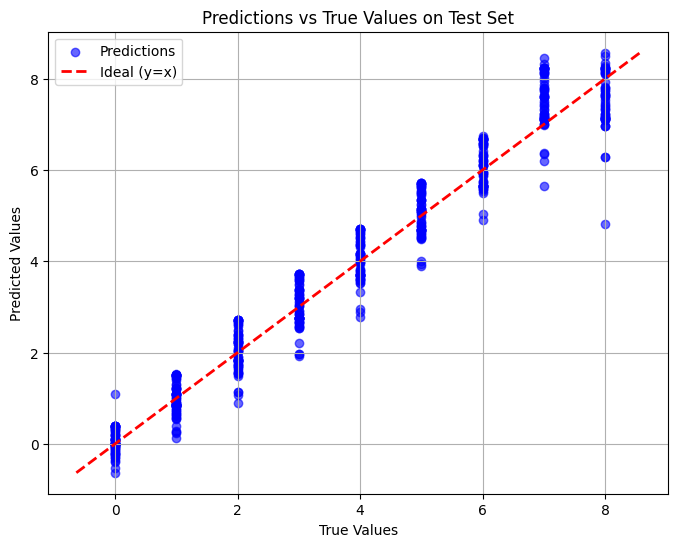

Randomly selected drive for visualization: ZA121K51
Selected candidate from drive ZA121K51 ending at 2024-01-25 00:00:00 with sequence label 2


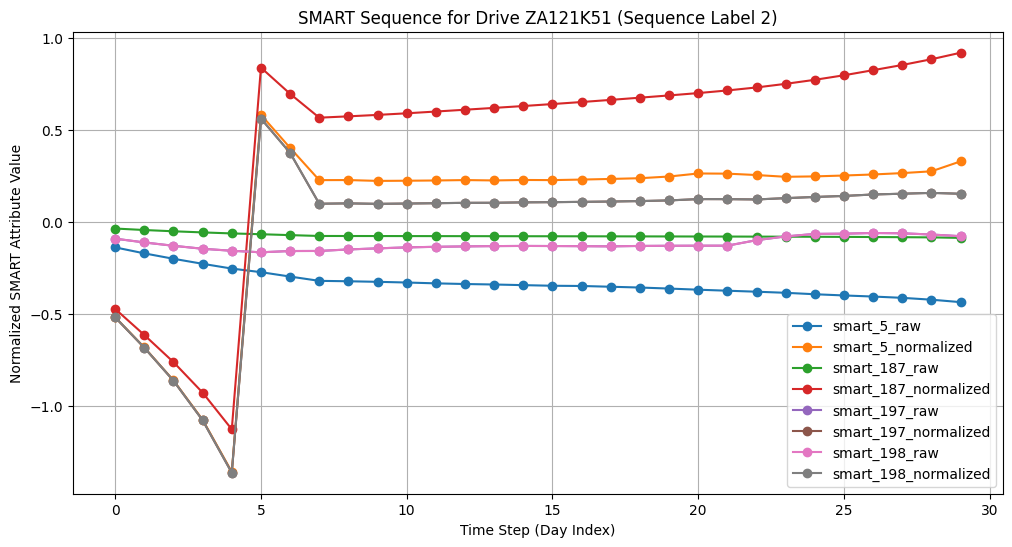


[INFO] Training pipeline completed successfully. Check TensorBoard and Optuna logs for details.


In [6]:
# Cell 3: Training Pipeline and Visualization

import time
import torch
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.exceptions import TrialPruned
import matplotlib.pyplot as plt
import numpy as np  # Make sure numpy is imported

# Helper functions for training, validation, and evaluation.
def train_one_epoch(model, dataloader, criterion, optimizer, device, writer, epoch):
    model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    
    writer.add_scalar("Loss/Train", avg_loss, epoch)
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(device) / 1e6  # MB
        reserved = torch.cuda.memory_reserved(device) / 1e6    # MB
        writer.add_scalar("GPU/Allocated_MB", allocated, epoch)
        writer.add_scalar("GPU/Reserved_MB", reserved, epoch)
    return avg_loss

def validate_one_epoch(model, dataloader, criterion, device, writer, epoch):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())
    avg_loss = total_loss / len(dataloader)
    writer.add_scalar("Loss/Validation", avg_loss, epoch)
    return avg_loss, all_preds, all_targets

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(targets.cpu().numpy().flatten())
    mse = mean_squared_error(all_targets, all_preds)
    return np.array(all_preds), np.array(all_targets), mse

# For simplicity, a simple model factory (replace with your actual model if needed).
import torch.nn as nn
def create_simple_model(lr, weight_decay, input_dim, hidden_dim, output_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )
    return model

# Load and split datasets using the new processed dataset.
def load_and_split_datasets(config):
    dataset_path = config["dataset"]["path"]
    full_dataset = SMARTDataset(data_directory=dataset_path)
    all_drives = list(full_dataset.drive_data.keys())
    print(f"[INFO] Total drives available: {len(all_drives)}")
    train_drives, test_drives = train_test_split(all_drives, test_size=0.2, random_state=42, shuffle=True)
    print(f"[INFO] Train drives: {train_drives}")
    print(f"[INFO] Test drives: {test_drives}")
    
    train_dataset = SMARTDataset(
        data_directory=dataset_path,
        drives_to_include=train_drives,
        days_before_failure=config["dataset"].get("days_before_failure", 30),
        sequence_length=config["dataset"].get("sequence_length", 30),
        smart_attribute_numbers=config["dataset"].get("smart_attribute_numbers", [5,187,197,198]),
        include_raw=config["dataset"].get("include_raw", True),
        include_normalized=config["dataset"].get("include_normalized", True),
        scaler=None,
        model_label_encoder=full_dataset.model_label_encoder,
    )
    
    test_dataset = SMARTDataset(
        data_directory=dataset_path,
        drives_to_include=test_drives,
        days_before_failure=config["dataset"].get("days_before_failure", 30),
        sequence_length=config["dataset"].get("sequence_length", 30),
        smart_attribute_numbers=config["dataset"].get("smart_attribute_numbers", [5,187,197,198]),
        include_raw=config["dataset"].get("include_raw", True),
        include_normalized=config["dataset"].get("include_normalized", True),
        scaler=train_dataset.scaler,
        model_label_encoder=full_dataset.model_label_encoder,
    )
    
    print(f"[INFO] Training dataset candidate sequences: {len(train_dataset)}")
    print(f"[INFO] Test dataset candidate sequences: {len(test_dataset)}")
    return train_dataset, test_dataset, full_dataset


global config  # Use the configuration from Cell 1.
num_trials = config["experiment"]["num_trials"]
num_epochs = config["experiment"]["num_epochs"]
final_epochs = config["experiment"]["final_epochs"]
batch_size = config["experiment"]["batch_size"]
k_folds = config["experiment"]["k_folds"]
early_stopping_patience = config["experiment"]["early_stopping_patience"]
fixed_hidden_dim = config["model"]["hidden_dim"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

train_dataset_full, test_dataset, full_dataset = load_and_split_datasets(config)

sample_features, _ = train_dataset_full[0]
input_dim = sample_features.shape[0]
print(f"[INFO] Input dimension: {input_dim}")

def train_one_fold(model, train_loader, val_loader, criterion, optimizer, writer, fold_idx=0, trial_idx=0, num_epochs=num_epochs):
    print(f"[INFO] >>> Starting fold {fold_idx+1} training (Trial #{trial_idx}) for {num_epochs} epochs...")
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, writer, epoch)
        val_loss, val_preds, val_targets = validate_one_epoch(model, val_loader, criterion, device, writer, epoch)
        print(f"[Fold {fold_idx+1} Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"[INFO] Early stopping on fold {fold_idx+1} at epoch {epoch+1}")
                break
    # Convert lists to NumPy arrays for plotting.
    val_targets_arr = np.array(val_targets)
    val_preds_arr = np.array(val_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(val_targets, val_preds, alpha=0.6, label="Val Predictions")
    lims = [min(val_targets_arr.min(), val_preds_arr.min()), max(val_targets_arr.max(), val_preds_arr.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label="Ideal (y=x)")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"Fold {fold_idx+1} Predictions vs True")
    ax.legend()
    writer.add_figure(f"Fold{fold_idx+1}/Pred_vs_True", fig, global_step=epoch)
    plt.close(fig)
    print(f"[INFO] <<< Finished fold {fold_idx+1}, best val loss = {best_val_loss:.4f}\n")
    return best_val_loss

def objective(trial):
    trial_lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    trial_weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    print(f"\n[OPTUNA] Starting Trial #{trial.number} with lr={trial_lr:.6f}, weight_decay={trial_weight_decay:.6f}")
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    all_indices = np.arange(len(train_dataset_full))
    writer_dir = f"{config['logging']['tensorboard_log_dir']}/optuna_trial_{trial.number}_{int(time.time())}"
    writer = SummaryWriter(writer_dir)
    fold_losses = []
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
        print(f"[OPTUNA] Trial #{trial.number}: Starting fold {fold_idx+1}/{k_folds}")
        from torch.utils.data import Subset
        train_subset = Subset(train_dataset_full, train_idx)
        val_subset = Subset(train_dataset_full, val_idx)
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        model_fold = create_simple_model(trial_lr, trial_weight_decay, input_dim, fixed_hidden_dim, output_dim=1).to(device)
        criterion_fold = torch.nn.MSELoss()
        optimizer_fold = torch.optim.Adam(model_fold.parameters(), lr=trial_lr, weight_decay=trial_weight_decay)
        best_val_loss = train_one_fold(model_fold, train_loader_fold, val_loader_fold, criterion_fold, optimizer_fold, writer, fold_idx, trial.number, num_epochs)
        fold_losses.append(best_val_loss)
    writer.close()
    avg_loss = np.mean(fold_losses)
    print(f"[OPTUNA] Trial #{trial.number} done. Fold Losses: {fold_losses}. Avg Loss={avg_loss:.4f}")
    trial.report(avg_loss, step=k_folds)
    if trial.should_prune():
        raise TrialPruned()
    return avg_loss

study_name = f"drive_regression_{int(time.time())}"
db_url = f"sqlite:///{study_name}.db"
import optuna
from optuna.exceptions import TrialPruned
study = optuna.create_study(study_name=study_name, storage=db_url, load_if_exists=False, direction='minimize')
print(f"[INFO] Starting study.optimize with {config['experiment']['num_trials']} trials...\n")
study.optimize(objective, n_trials=config["experiment"]["num_trials"])
best_trial = study.best_trial
print("[OPTUNA] Best trial found:")
print(f"  Trial number: {best_trial.number}")
print(f"  Avg k-fold loss: {best_trial.value:.4f}")
for k, v in best_trial.params.items():
    print(f"    {k}: {v}")
best_lr = best_trial.params['lr']
best_weight_decay = best_trial.params['weight_decay']

print("\n[INFO] Retraining final model on the entire training set using best hyperparameters...")
final_model = create_simple_model(best_lr, best_weight_decay, input_dim, fixed_hidden_dim, output_dim=1).to(device)
final_criterion = torch.nn.MSELoss()
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
final_train_loader = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True)
writer_final = SummaryWriter(f"{config['logging']['tensorboard_log_dir']}/final_training_{int(time.time())}")
for epoch in range(config["experiment"]["final_epochs"]):
    train_loss = train_one_epoch(final_model, final_train_loader, final_criterion, final_optimizer, device, writer_final, epoch)
    writer_final.add_scalar("Final_Train_Loss", train_loss, epoch)
    print(f"[Final Train] Epoch {epoch+1}/{config['experiment']['final_epochs']} - Loss: {train_loss:.4f}")
writer_final.close()

final_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
all_preds, all_targets, test_mse = evaluate_model(final_model, final_test_loader, device)
print(f"\n[RESULT] Final Test MSE: {test_mse:.4f}\n")

plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_preds, color='blue', alpha=0.6, label='Predictions')
lims = [min(min(all_targets), min(all_preds)), max(max(all_targets), max(all_preds))]
plt.plot(lims, lims, 'r--', linewidth=2, label='Ideal (y=x)')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs True Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()

train_drive_ids = list(train_dataset_full.drive_data.keys())
if not train_drive_ids:
    raise ValueError("No drive data available in training dataset.")
random_drive = random.choice(train_drive_ids)
print("Randomly selected drive for visualization:", random_drive)

drive_candidates = [entry for entry in train_dataset_full.index_mapping if entry[0] == random_drive]
if not drive_candidates:
    raise ValueError("No candidate sequences found for drive: " + random_drive)
selected_candidate = random.choice(drive_candidates)
drive_id, end_date, seq_label = selected_candidate
print(f"Selected candidate from drive {drive_id} ending at {end_date} with sequence label {seq_label}")

sequence = train_dataset_full._generate_sequence(drive_id, end_date)
if sequence is None:
    raise ValueError("The candidate sequence could not be generated.")
if train_dataset_full.scaler is not None:
    sequence[1:] = train_dataset_full.scaler.transform(sequence[1:].reshape(1, -1))[0]
model_encoded = sequence[0]
flattened_data = sequence[1:]
num_attributes = len(train_dataset_full.smart_attributes)
sequence_array = flattened_data.reshape(train_dataset_full.sequence_length, num_attributes)

plt.figure(figsize=(12, 6))
for i in range(num_attributes):
    plt.plot(range(train_dataset_full.sequence_length), sequence_array[:, i], marker='o', label=train_dataset_full.smart_attributes[i])
plt.xlabel("Time Step (Day Index)")
plt.ylabel("Normalized SMART Attribute Value")
plt.title(f"SMART Sequence for Drive {drive_id} (Sequence Label {seq_label})")
plt.legend()
plt.grid(True)
plt.show()

print("\n[INFO] Training pipeline completed successfully. Check TensorBoard and Optuna logs for details.")



Collected candidate sequences for drives: ['ZHZ36BRQ', 'ZL0051J0', 'ZHZ65F05', 'ZL00535K', 'ZHZ0NN8H', 'ZHZ45LEC', 'ZHZ3CHDX', 'ZJV0NPT1', 'ZA12HZZV', 'ZHZ62N7Y']


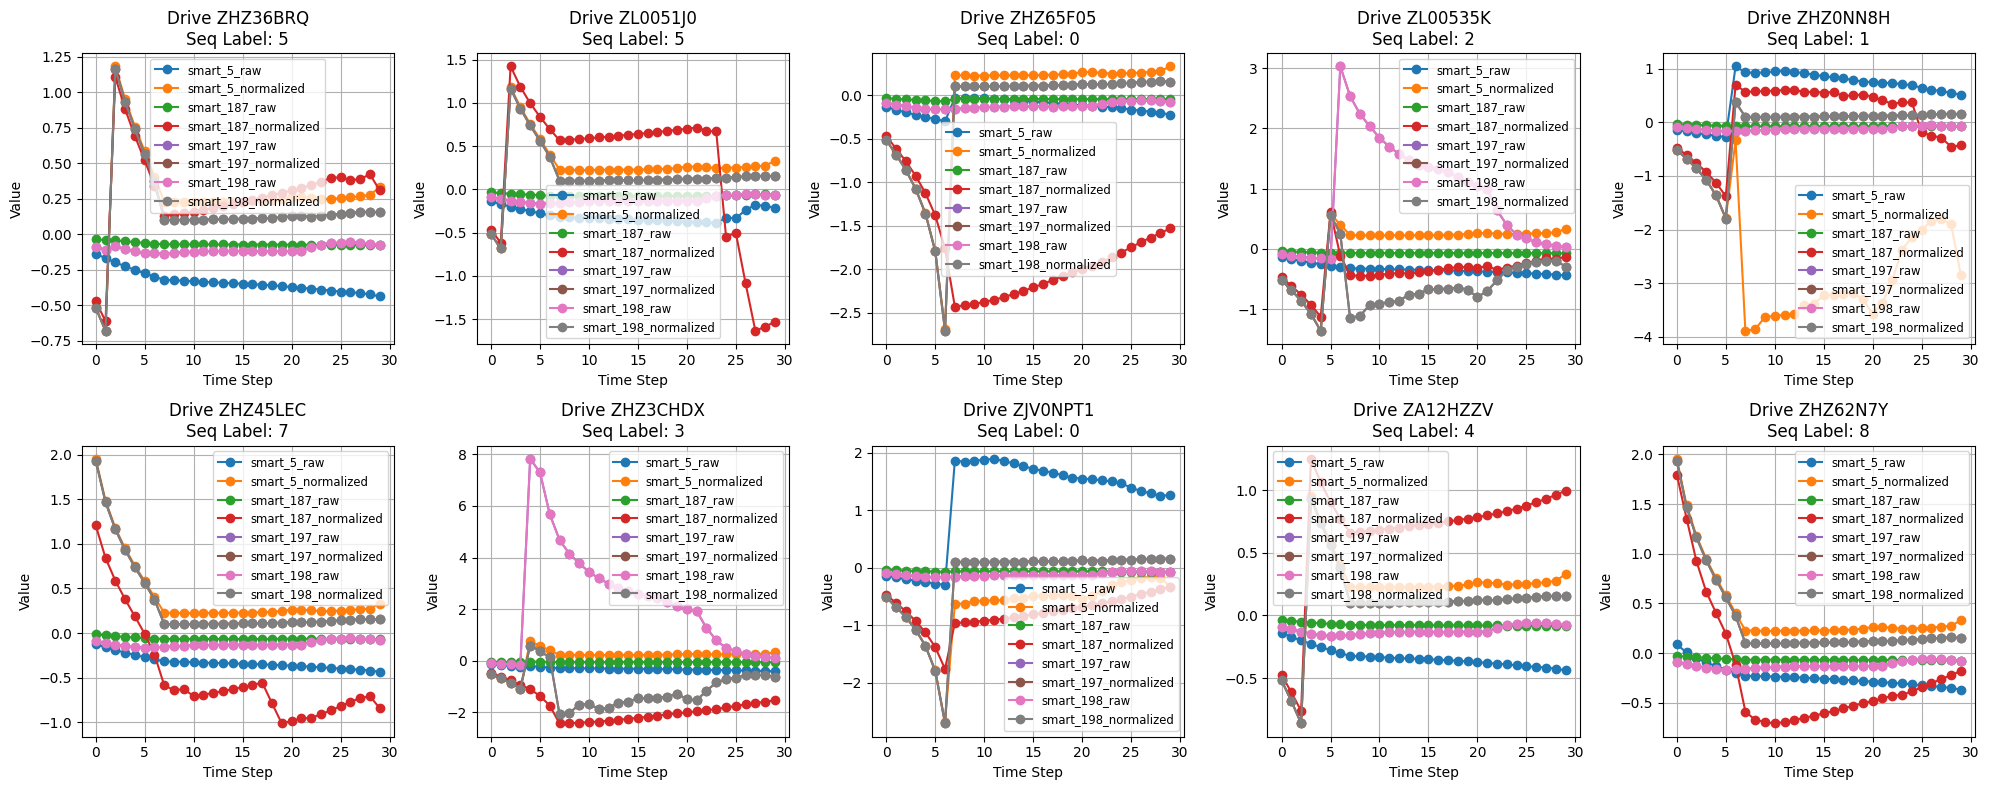

In [16]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Try to accumulate 10 valid candidate sequences.
valid_candidates = []
max_attempts = 200  # Maximum attempts to find 10 valid drives
attempts = 0

while len(valid_candidates) < 10 and attempts < max_attempts:
    random_drive = random.choice(list(train_dataset_full.drive_data.keys()))
    # Filter candidate sequences for this drive.
    drive_candidates = [entry for entry in train_dataset_full.index_mapping if entry[0] == random_drive]
    if not drive_candidates:
        attempts += 1
        continue  # No candidate for this drive, try another.
    
    candidate = random.choice(drive_candidates)
    drive_id, end_date, seq_label = candidate
    # Try generating the sequence.
    sequence = train_dataset_full._generate_sequence(drive_id, end_date)
    if sequence is None:
        attempts += 1
        continue  # Sequence generation failed; try another candidate.
    
    # If we got here, the candidate is valid.
    valid_candidates.append(candidate)
    attempts += 1

if len(valid_candidates) < 10:
    raise ValueError("Could not collect 10 valid candidate sequences after many attempts.")

print("Collected candidate sequences for drives:", [cand[0] for cand in valid_candidates])

# Set up a 2x5 grid for subplots.
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Plot each candidate sequence in a separate subplot.
for i, candidate in enumerate(valid_candidates):
    drive_id, end_date, seq_label = candidate
    sequence = train_dataset_full._generate_sequence(drive_id, end_date)
    if sequence is None:
        axs[i].text(0.5, 0.5, f"Seq gen failed for drive {drive_id}", ha="center", va="center")
        axs[i].axis('off')
        continue
    if train_dataset_full.scaler is not None:
        sequence[1:] = train_dataset_full.scaler.transform(sequence[1:].reshape(1, -1))[0]
    # Exclude the first element (model_encoded) for plotting SMART attributes.
    flattened_data = sequence[1:]
    num_attributes = len(train_dataset_full.smart_attributes)
    sequence_array = flattened_data.reshape(train_dataset_full.sequence_length, num_attributes)
    
    ax = axs[i]
    for j in range(num_attributes):
        ax.plot(range(train_dataset_full.sequence_length), sequence_array[:, j], marker='o', label=train_dataset_full.smart_attributes[j])
    ax.set_title(f"Drive {drive_id}\nSeq Label: {seq_label}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()


Selected candidate sequences (drive IDs with seq label 0):
Drive: ZA180Z6E, End Date: 2024-01-24 00:00:00, Label: 0
Drive: ZHZ4X93L, End Date: 2024-03-06 00:00:00, Label: 0
Drive: ZCH05M9N, End Date: 2024-01-24 00:00:00, Label: 0
Drive: ZLW0GQ78, End Date: 2024-02-26 00:00:00, Label: 0
Drive: ZL2D9DR8, End Date: 2024-02-02 00:00:00, Label: 0
Drive: ZHZ3R0E0, End Date: 2024-03-17 00:00:00, Label: 0
Drive: ZHZ5V0SJ, End Date: 2024-02-13 00:00:00, Label: 0
Drive: ZJV3AA41, End Date: 2024-03-19 00:00:00, Label: 0
Drive: ZL00560T, End Date: 2024-02-03 00:00:00, Label: 0
Drive: ZHZ3Z6XP, End Date: 2024-02-16 00:00:00, Label: 0


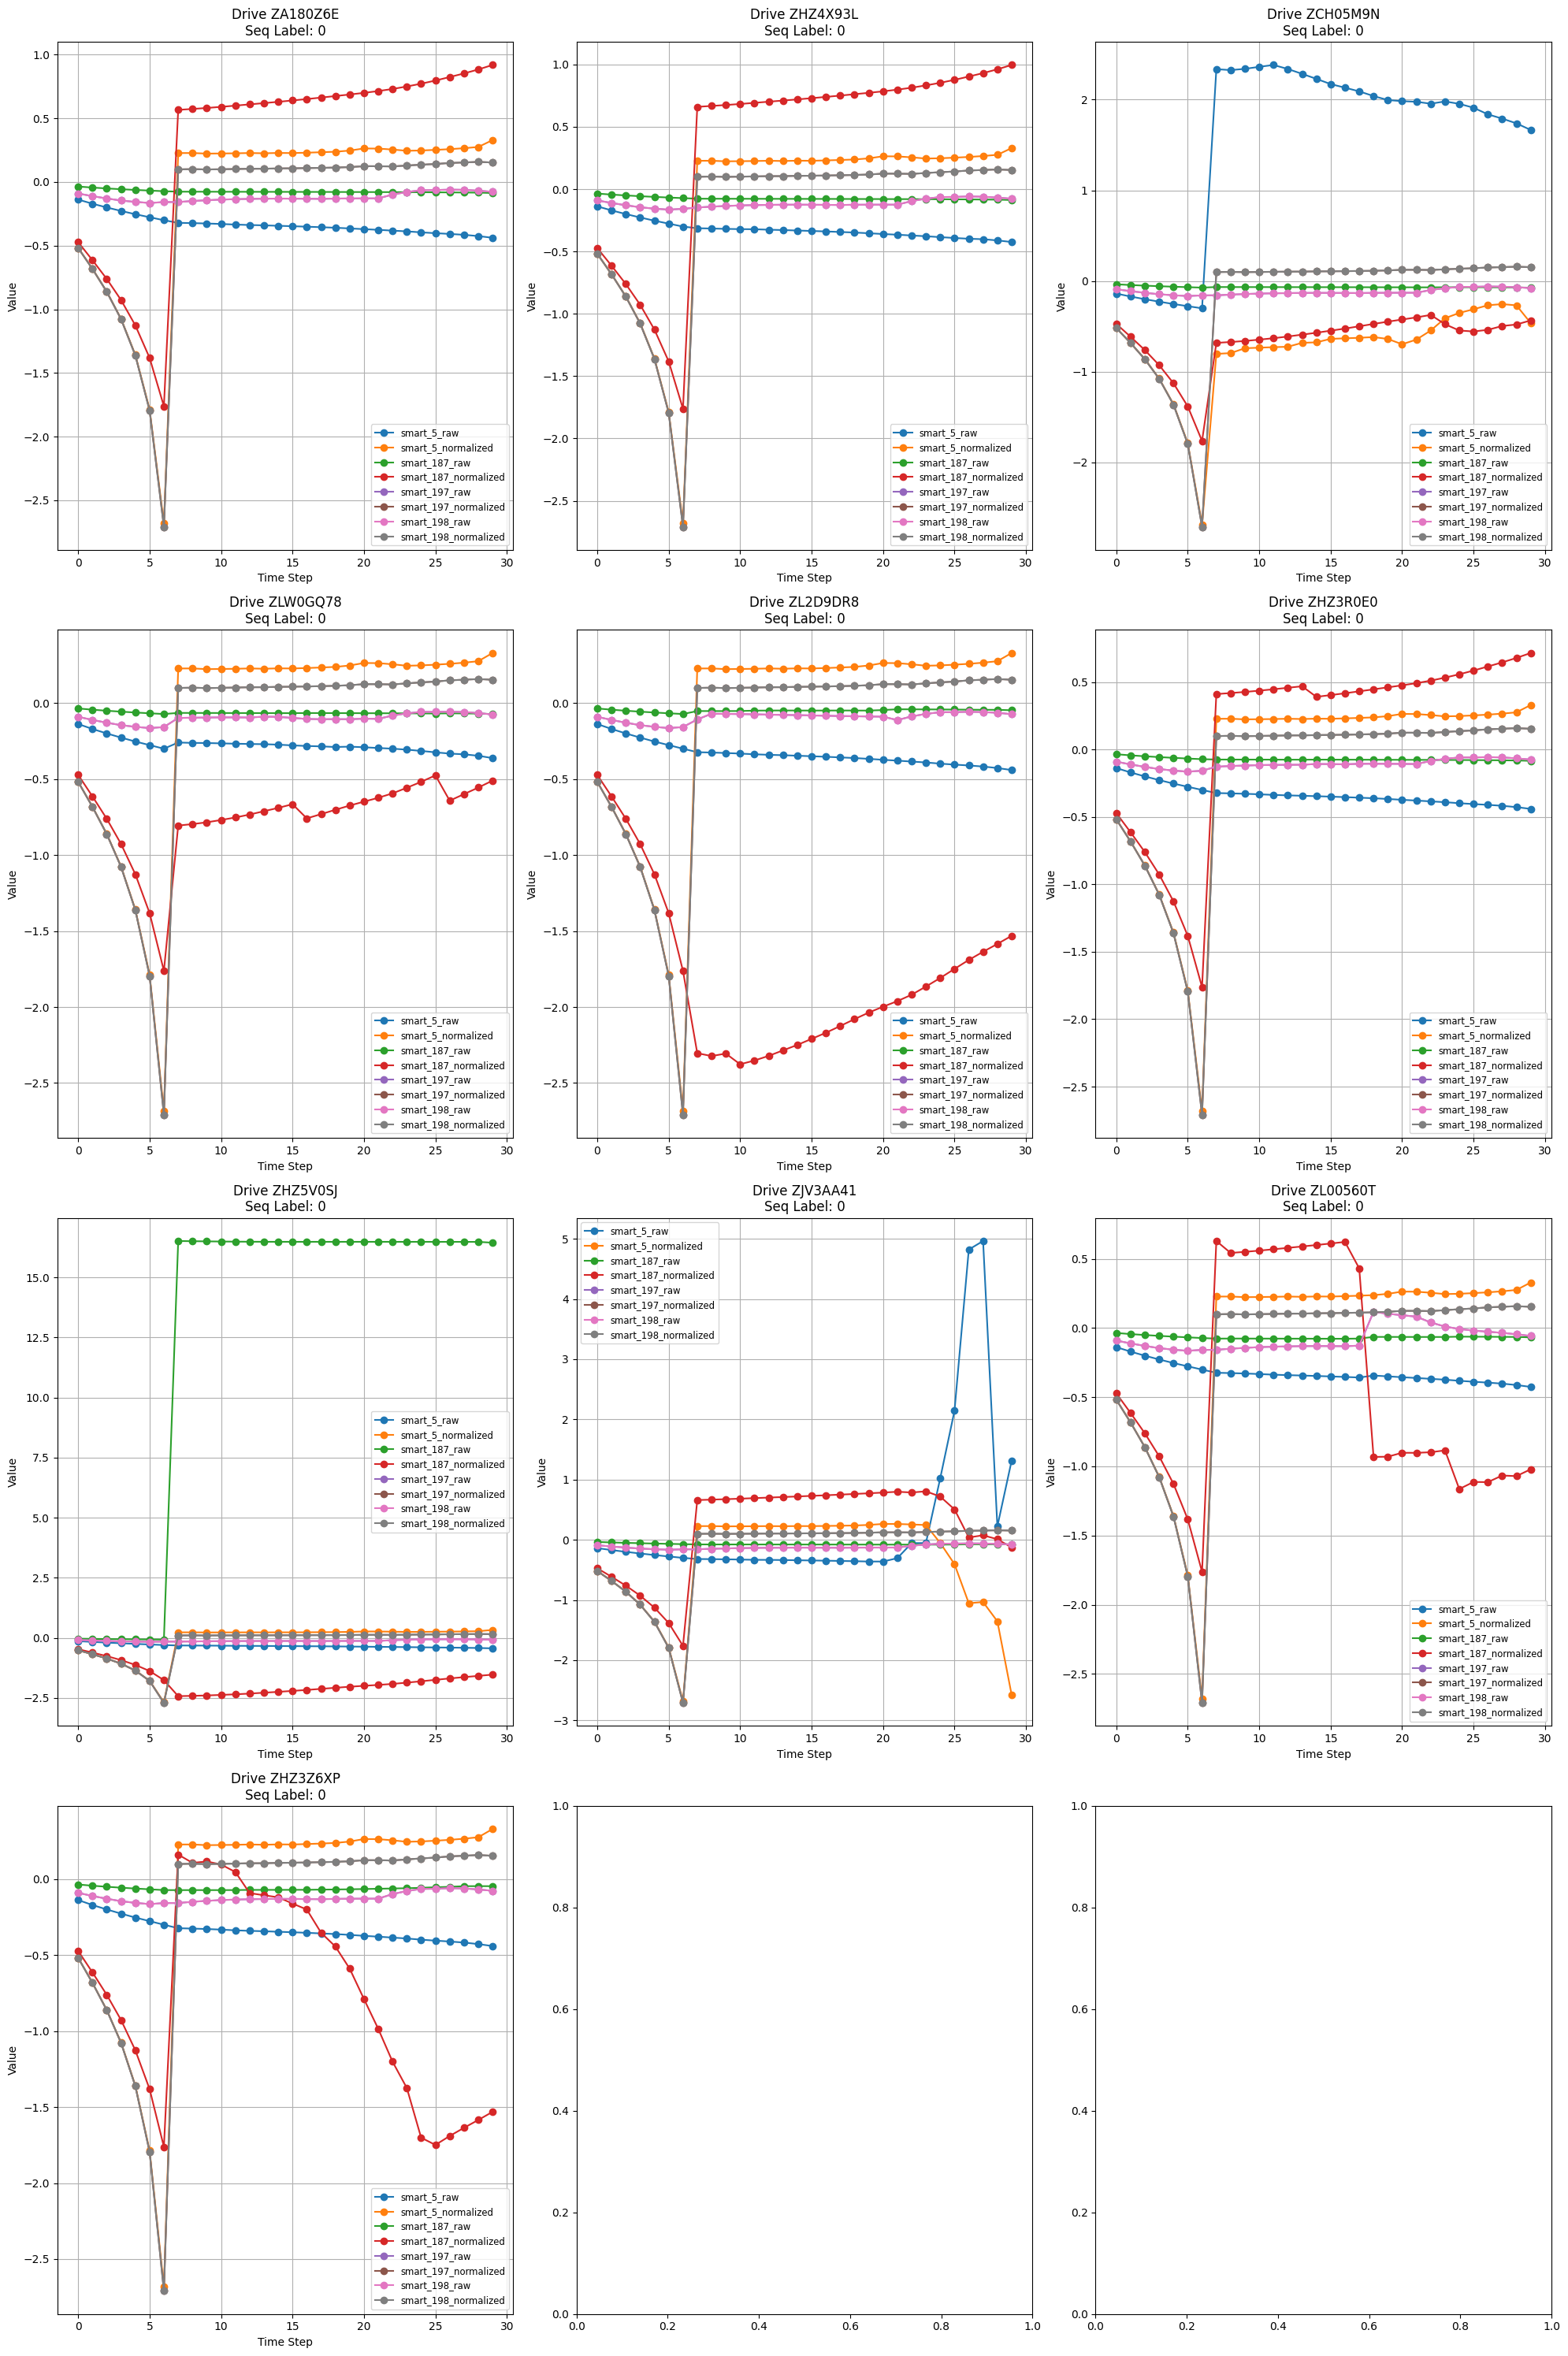

In [21]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Collect candidate sequences with sequence label 0 (the first valid sequence of each drive)
seq0_candidates = [entry for entry in train_dataset_full.index_mapping if entry[2] == 0]

if len(seq0_candidates) == 0:
    raise ValueError("No candidate sequences with label 0 found in the training dataset.")

# If more than 10 candidates are available, randomly sample 10 (from distinct drives if possible).
# We can try grouping by drive and then sampling one candidate per drive.
drive_candidates = {}
for cand in seq0_candidates:
    drive = cand[0]
    # For each drive, keep the candidate with label 0 (should be only one per drive)
    drive_candidates[drive] = cand

all_seq0_candidates = list(drive_candidates.values())
if len(all_seq0_candidates) > 10:
    selected_candidates = random.sample(all_seq0_candidates, 10)
else:
    selected_candidates = all_seq0_candidates

print("Selected candidate sequences (drive IDs with seq label 0):")
for cand in selected_candidates:
    print(f"Drive: {cand[0]}, End Date: {cand[1]}, Label: {cand[2]}")

# Plot the candidate sequences in a 2x5 grid.
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
axs = axs.flatten()

for i, candidate in enumerate(selected_candidates):
    drive_id, end_date, seq_label = candidate
    sequence = train_dataset_full._generate_sequence(drive_id, end_date)
    if sequence is None:
        axs[i].text(0.5, 0.5, f"Seq gen failed for drive {drive_id}", ha="center", va="center")
        axs[i].axis('off')
        continue
    if train_dataset_full.scaler is not None:
        sequence[1:] = train_dataset_full.scaler.transform(sequence[1:].reshape(1, -1))[0]
    flattened_data = sequence[1:]  # Exclude model_encoded.
    num_attributes = len(train_dataset_full.smart_attributes)
    try:
        sequence_array = flattened_data.reshape(train_dataset_full.sequence_length, num_attributes)
    except Exception as e:
        axs[i].text(0.5, 0.5, f"Reshape error: {e}", ha="center", va="center")
        axs[i].axis('off')
        continue

    ax = axs[i]
    for j in range(num_attributes):
        ax.plot(range(train_dataset_full.sequence_length), sequence_array[:, j], marker='o', label=train_dataset_full.smart_attributes[j])
    ax.set_title(f"Drive {drive_id}\nSeq Label: {seq_label}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [9]:
# Evaluate the Final Model on the Test Set
final_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
all_preds, all_targets, test_mse = evaluate_model(final_model, final_test_loader, device)
print(f"\n[RESULT] Final Test MSE: {test_mse:.4f}\n")




[RESULT] Final Test MSE: 0.2710



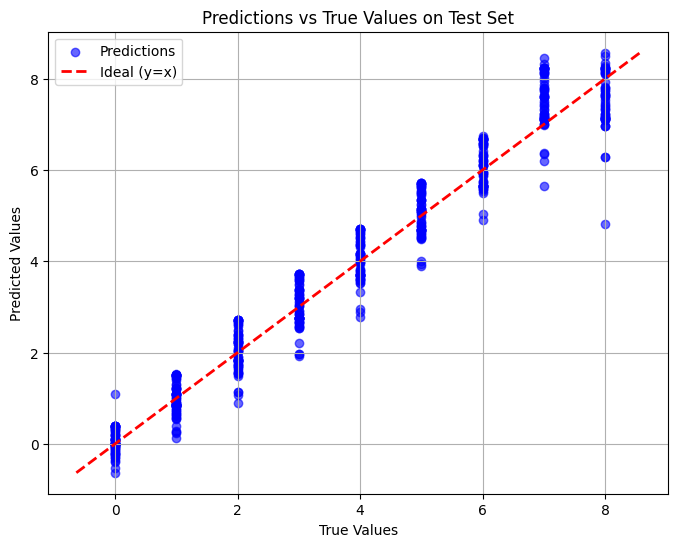

In [7]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_preds, color='blue', alpha=0.6, label='Predictions')
# Plot the ideal line (y=x)
min_val = min(min(all_targets), min(all_preds))
max_val = max(max(all_targets), max(all_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal (y=x)')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs True Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()
